<a href="https://colab.research.google.com/github/BitKnitting/FitHome_DeepLearning_1/blob/master/DeepLearning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIY Sensors and Deep Learning Applied to Insights into Electricity Use

Our planet gets healthier the more we rely on renewable, clean energy.  A challenge for us to get there is the amount of electricity we use.  This trend will continue as we add electric cars and more efficient electric appliances into our lifestyle.  But while we add, it amazes me how much we waste! I was humbled to find out our house was using 40% more electricity than we needed!  I don't believe my experience is unique.  Most likely, many other houses are wasting a significant amount of electricity.  If we all knew how much we were wasting, we would not waste as much.

The key is knowing how we are using electricity in our homes.  What devices suck up the most electricity?  When?  Why so much?  Are some devices wasting electricity?  Are there devices that are sucking up electricity we didn't know were on?

## The Project and Its Goals
In this project we will explore electronics, python, and deep learning to determine how much electricity each of our major devices are using.  This is currently a research field commonly refered to as NILM (for Non Intrusive Load Monitoring).  [This paper](https://github.com/BitKnitting/transfer_nilm_exploration/blob/master/documents/Sequence-to-point%20learning%20with%20neural%20networks%20for%20non-intrusive%20load%20monitoring.pdf) is an example of NILM research.  

Most of the NILM research uses publicly available datasets.  We'll collect our data from our homes using electricity monitors.  

The electricity readings will go into a mongo db running on a Rasp Pi.  

Once enough readings are collected, we'll feed the readings into colab notebooks and explore deep learning methods to extract a device's electricity use from the aggregate electricity readings.

# A Learning Opportunity
This project is for folks that are passionate about learning electronics, python, and deep learning.  Let us start a study group where we video conference once a week to evolve our project.  Our goal is to learn from eachother about electronics, python, and deep learning as we build the parts of the system.  

__Please email me if you are interested.__

# The Goal of this Notebook
This notebook is a starting off point for our study group.  We will use colab notebooks as a way to document and evolve our learning and understanding of the different technologies we'll be working on.




I want to apply my learnings in DIY
The goal of this project is to detect whether a microwave is on or off based on a home's aggregate electricity readings.
## Why Do This

# Components

To do this, we will:
- build the software that controls the power monitors:
  - [Micropython firmware for the Circuit Setup energy monitor](https://github.com/BitKnitting/FitHome/wiki/ElectricityMonitor)  
  - [Rasp Pi software for the HS110 Smart Plugs](https://github.com/BitKnitting/FitHome/wiki/PlugE)  
- write the code to collect the readings into a mongo db running on a [Rasp Pi](https://github.com/BitKnitting/FitHome/wiki/RaspPi)


 I build electricity power monitors and additional software to collect our home's power readings.  The next step is to feed the readings into a Deep neural network.  The input to the Deep neural network are a timeseries of power readings.  The output is an estimate of how much electricity (and when) our Microwave was on.
# Why
- I pack up my bags and go on a terrific learning vacation!
  - What is all this AI about?
  - All the software and hardware that must come together to enable this scenario is an intriguing challenge.
- There's been some amount of research into NILM (Non-Intrusive Load Monitoring).  Since I am excited by the prospect if we knew how our elecricity was being used we could save at least 15%, it would be relevant to know how an appliance is using electricity.
- The project holds my interest because of the software and hardware that must come together to enable the scenario.  There is much to learn!

![overview](images/overview.png)
# Input Data
## Existing Datasets
The NILM literature discusses [several available datasets](http://wiki.nilm.eu/datasets.html) to use when exploring aggregate electricity reading disaggregation.  I have experimented with both the REDD and UK-Dale datasets.


## My Data Collection
I decided to collect my own data because it gives me complete insight to everything that goes into how sensor get readings from breaker boxes and plugs to how data is cleaned and used within a Jupyter notebook.  It allowed me the flexibility to define what features to collect, when, and what.

I chose a sampling rate of 1 second because:
- I want samples taken with the shortest amount of time between readings.
- There is a > 98% chance the system can record the samples within this time period.
### Feature Extraction
The Features that I will use in the model include:
- __Aggregate power readings__ come from [a FitHome monitor at the breaker box](https://github.com/BitKnitting/FitHome/wiki/ElectricityMonitor).  I have slightly modified the monitor's firmware for this project.
- __Aggregate reactive power readings__ As pointed out [in this article](https://www.elprocus.com/importance-of-reactive-power-in-power-system-network/), _Transformers, motors, generators and other electrical devices require reactive power to produce magnetic flux._ Devices like hair dryers, lamps, heaters - those things that use all the power don't need reactive power.  By including reactive power as a feature, devices can be included or eliminated based on the amount of reactive power they require.
- __Hour of the day__: Many appliances - like the microwave - are typically used at the same time each day.  By using this feature, I am expecting the modeling will be better.  
  
I will not send current and voltage readings because active power as a [feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) of current and voltage because P = IV.

### Target Data
The target data are the active power and current readings from the electricity monitor hooked up to the microwave.  The monitor I'm using on the microwave is a Smart Plug.  Post capture, I can take these readings and determine when the microwave was on or off.  I can then convert these two columns (active power and current) into a category column in which 1 = microwave is on and 0 = microwave is off.

# Monitor Code
__TODO: SystemD services__

Two monitors will be used:
-  One at the breaker box to capture aggregate active and reactive power.  I am modifying the code I use for the [FitHome monitor](https://github.com/BitKnitting/FitHome/wiki/ElectricityMonitor) to work with this project.  The code is in this GitHub repository.
- A [TP-LINK HS110](https://github.com/BitKnitting/FitHome/wiki/PlugE) 
One at the microwave that will send a 1 when the microwave is on, a 0 when it is off.  I call the software I wrote [PlugE](https://github.com/BitKnitting/FitHome/wiki/PlugE) to reflect the code "goo" needed to get readings from the HS110 and figure out if the microwave is on or off.
## Send Readings  
The two monitors independently send readings.  These are put in the mongodb database running on the Rasp Pi.  Both are within the FitHome DB.  The aggregate data is in the aggregate collection.  The microwave data is in the microwave collection.
## Collect Readings
I run two Systemd services on the Rasp Pi:
- `PlugE_microwave.service`  This is an evolution of [the PlugE service discussed here](https://github.com/BitKnitting/FitHome/wiki/PlugE#systemd-service).
```
[Unit]
Description=Collect microwave readings into mongodb.
# Don't start the service until the network is up and running
After=network.target

[Service]
Type=simple
# ExecStart=/usr/bin/python3 /home/pi/projects/FitHome_PlugE/PlugE/plug_microwave.py
ExecStart = /home/pi/projects/FitHome_PlugE/PlugE/plug_microwave.py
Restart=on-failure
User=pi

[Install]
# Components of this application should be started at boot time
WantedBy=multi-user.target
```
__NOTE: Make sure to include the shebang command at the beginning of the .py script__:  
```
#!/home/pi/projects/FitHome_PlugE/PlugE/venv/bin/python3
from pyHS100 import SmartPlug, Discover
from plug_lib import Plug, MongoDB

db = MongoDB("mongodb://localhost:27017/", "FitHome", "microwave")
plug = Plug("microwave", db, detect_on=False)
plug.start()
```

# Data Pipeline
## MongoDB to Zip files
The first step in the data pipeline is to get the aggregate and microwave readings out of mongodb and into two Pandas dataframes that are then compressed into Zip file.  
  
The [mongo_to_pandas script](https://github.com/BitKnitting/FitHome_mongodb/blob/master/data_results/mongo_to_pandas) takes in the database, collection names of the data in the mongo db as well as an output name for the file and:
- Exports readings in the collection into a .json file.
- Takes the .json file and pickles it using the [json_to_pickle.py](https://github.com/BitKnitting/FitHome_mongodb/blob/master/data_results/json_to_pickle.py) Python script.
- Zips the pickled file into the <filename>.pkl.zip filename.

Run within the mongodb project using the command: `$ . mongo_to_pandas`



In [11]:
# @title imports
import pandas as pd
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/ziptodf.py
import ziptodf
!wget https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/plots.py
import plots

--2019-12-26 12:22:26--  https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/ziptodf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1361 (1.3K) [text/plain]
Saving to: ‘ziptodf.py.2’

ziptodf.py.2        100%[===================>]   1.33K  --.-KB/s    in 0s      

2019-12-26 12:22:26 (310 MB/s) - ‘ziptodf.py.2’ saved [1361/1361]

--2019-12-26 12:22:27--  https://raw.githubusercontent.com/BitKnitting/transfer_nilm_exploration/master/code/python_lib/plots.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 O

# Load and Prepare Data
Data has been retrieved from the mongo db running on the Rasp Pi according to [these directions](......

In [0]:
def load_and_prepare_data():
  # Get the aggregate data and the microwave data
  aggregate = ziptodf.get_dataframe_from_pkl_zip('https://raw.githubusercontent.com/BitKnitting/FitHome_DeepLearning_1/master/data/aggregate.pkl.zip')
  microwave = ziptodf.get_dataframe_from_pkl_zip('https://raw.githubusercontent.com/BitKnitting/FitHome_DeepLearning_1/master/data/microwave.pkl.zip')
  # Merge based on sample timestamp
  df_merge = pd.merge_asof(aggregate,microwave,on='timestamp',tolerance=pd.Timedelta(seconds=1))
  # Drop Rows where there is NaN
  df_data = df_merge.dropna()
  # Set index to timestamp
  df_data = df_data.set_index('timestamp')
  # Create an Hour column
  hours = df_data.index.hour
  df_hours = pd.DataFrame(hours,index=df_data.index)
  df_hours = df_hours.rename({'timestamp': 'Hours'}, axis='columns')
  # Add the hours column to the dataframe.
  df_data = pd.concat((df_data,df_hours),axis=1)
  return df_data


In [0]:
df_data = load_and_prepare_data()

In [4]:
ziptodf.print_stats(df_data,"Data")

Data
**************************
Start index: 2019-12-21 16:09:48.570688963-08:00
--------------------------
End index: 2019-12-22 03:47:56.671520948-08:00
--------------------------
Rank: 2
--------------------------
Shape: (18862, 5)
--------------------------
Data types: 
Pa       float64
Pr       float64
P        float64
I        float64
Hours      int64
dtype: object
--------------------------
Number of missing values:
Pa       0
Pr       0
P        0
I        0
Hours    0
dtype: int64
--------------------------
Summary Stats:
                  Pa            Pr             P             I         Hours
count  18862.000000  18862.000000  18862.000000  18862.000000  18862.000000
mean     362.446809     85.004896      2.413836      0.333256     13.561658
std      364.108512    161.868294     54.167327      0.487982      8.759437
min        0.747520      0.019520      0.452913      0.302819      0.000000
25%      111.521325      9.052319      0.569768      0.316139      2.000000
50%   

# Explore Reading Gaps
There will be (many) times when the Rasp Pi won't get a reading from a monitor.  There could be something wrong with the wifi.  I've had interference from the microwave prevent the Smart Plug from being able to read and send data.  In this section. I explore the sampling rate.
- what is the most common sampling rate?
- what gaps are there between readings?
- what is going on when the largest gaps occur?

## The Most Common Sampling Rate
First, I'll look at the distribution of sampling rates.  I find looking at a box plot and binning the sampling rate values is easiest to quickly get an idea.

In [0]:
# @title Show Distribution of Sampling Rates
# Given the readings, returns a series of seconds between each reading.
# while the content is a timestamp, the datatype is an object.
def get_sample_rates(df):
  time_between_samples = df.index.to_series().diff()
  delta_seconds = df.index.to_series().diff().dt.seconds
  # Box Plot 
  ax = delta_seconds.plot.box(figsize=(3,15))
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  # Bins
  df_bins = delta_seconds.value_counts(bins=10000)
  print('Number of Samples within each bin (unit is seconds)')
  display(df_bins.head(15))
  # The first row will be NaN since it's about the time between samples.
  return time_between_samples[1:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


Number of Samples within each bin (unit is seconds)


(1.8090000000000002, 2.019]    18287
(3.995, 4.014]                   470
(2.988, 3.007]                    62
(4.983, 5.002]                    32
(6.997, 7.016]                     3
(5.99, 6.009]                      2
(78.988, 79.007]                   1
(10.987, 11.006]                   1
(12.982, 13.001]                   1
(22.995, 23.014]                   1
(191.981, 192.0]                   1
(191.772, 191.791]                 0
(65.175, 65.194]                   0
(65.308, 65.327]                   0
(65.289, 65.308]                   0
Name: timestamp, dtype: int64

count                     18861
mean     0 days 00:00:02.220884
std      0 days 00:00:01.555812
min      0 days 00:00:02.119560
25%      0 days 00:00:02.132773
50%      0 days 00:00:02.136665
75%      0 days 00:00:02.141902
max      0 days 00:03:12.965981
Name: timestamp, dtype: object

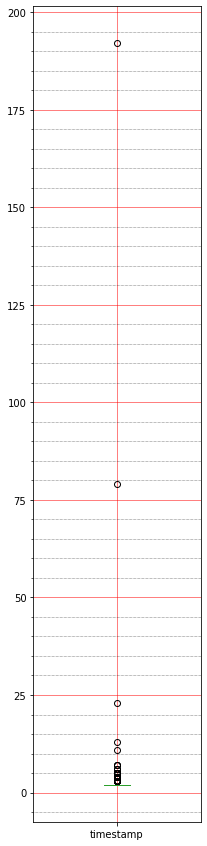

In [6]:
df_time_between_samples = get_sample_rates(df_data)
df_time_between_samples.describe()

### Results - Most Common Sampling Rate
The majority of samples are two seconds apart.  Followed by 4,3,5, 7, 6 seconds.  

### Results - Large Gaps
There are 5 readings that are > 10 seconds from their previous reading.  What does the data look like around the gap?  Can I tell if it is because the microwave caused interference?  Can I intuit other reasons knowing how we use electricity?

# Exploring Gaps > 10 seconds
The "best" way for me to understand where and what is happening when > 10 seconds pass between two readings is to visualize each with a plot. 

In [0]:
import matplotlib.pyplot as plt
# @title Look more closely at samples where the sampling rate was much larger than the majority.
# df = dataframe of all samples.
# df_time_between_samples = the amount of seconds between readings.  This dataseries
# was created through a call to get_sample_rates()
# gap - the number of seconds until the time between samples is considered large.
def plot_gaps(df,df_time_between_samples,gap=10):
  # A row is True if it's timestamp is gap seconds more than the previous timestamp.
  filter = df_time_between_samples > pd.Timedelta(gap, unit='s')
  df_more_than_gap = df_time_between_samples.loc[filter]
  # Go through each reading that is at least 10s later than a previous reading
  print(f'\n***There are {len(df_more_than_gap)} large gaps between samples.***')
  # For each, make a plot based on the two gap points as well as a few earlier and later samples.
  for i in range(len(df_more_than_gap)):
    print(f'**** #{i+1}')
    sample_time = df_more_than_gap.index[i]
    print(sample_time)
    time_delta = df_more_than_gap[i]
    print(time_delta)
    m = 2
    while True:
      earlier = sample_time - m*time_delta
      later = sample_time + time_delta/4
      cnt = len(df[(df.index >= earlier) & (df.index <= later)])

      
      print(f'count: {cnt}')
      if (cnt <= 25):
        break
      m -= .2
    df_plot = df[(df.index >= earlier) & (df.index <= later)]  
    print(f'df plot type: {type(df_plot)}')
    min_timestamp = df_plot.index.min()

    if (sample_time == min_timestamp):
      df_plot.index.shift(-10,freq='s')
    print(f'minimum timestamp: {df_plot.index.min()}, maximum timestamp: {df_plot.index.max()}')
    ax = df_plot.plot(style = '.-',figsize=(16,10),ms=12)
    ax.minorticks_on()
    ax.set_title(f'Gap size: {time_delta.seconds}s...Sample time: {sample_time}')
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
 



  


***There are 5 large gaps between samples.***
**** #1
2019-12-21 16:15:42.285301924-08:00
0 days 00:00:13.026693
count: 8
df plot type: <class 'pandas.core.frame.DataFrame'>
minimum timestamp: 2019-12-21 16:15:18.252271891-08:00, maximum timestamp: 2019-12-21 16:15:44.494807959-08:00
**** #2
2019-12-21 18:18:56.186455011-08:00
0 days 00:01:19.381649
count: 46
count: 38
count: 31
count: 24
df plot type: <class 'pandas.core.frame.DataFrame'>
minimum timestamp: 2019-12-21 18:17:05.656713009-08:00, maximum timestamp: 2019-12-21 18:19:15.570763111-08:00
**** #3
2019-12-21 20:08:51.766695023-08:00
0 days 00:03:12.965981
count: 109
count: 91
count: 73
count: 55
count: 39
count: 22
df plot type: <class 'pandas.core.frame.DataFrame'>
minimum timestamp: 2019-12-21 20:05:38.800713062-08:00, maximum timestamp: 2019-12-21 20:09:38.818495989-08:00
**** #4
2019-12-21 22:37:01.541093111-08:00
0 days 00:00:23.040646
count: 14
df plot type: <class 'pandas.core.frame.DataFrame'>
minimum timestamp: 2019-

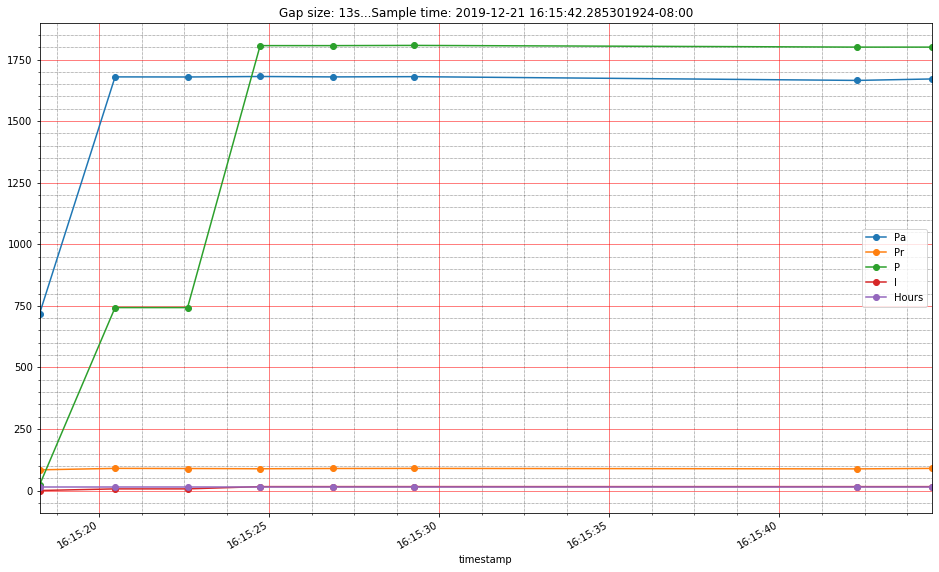

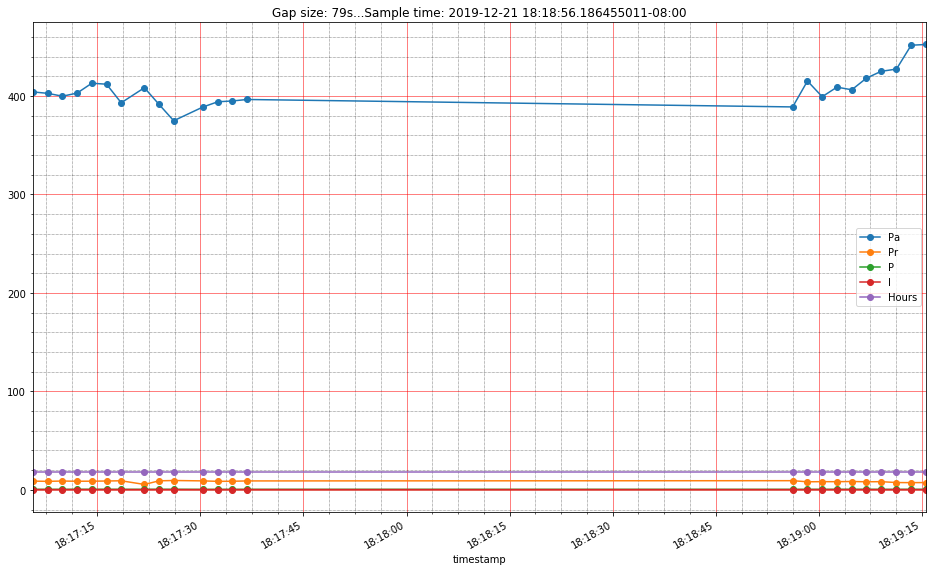

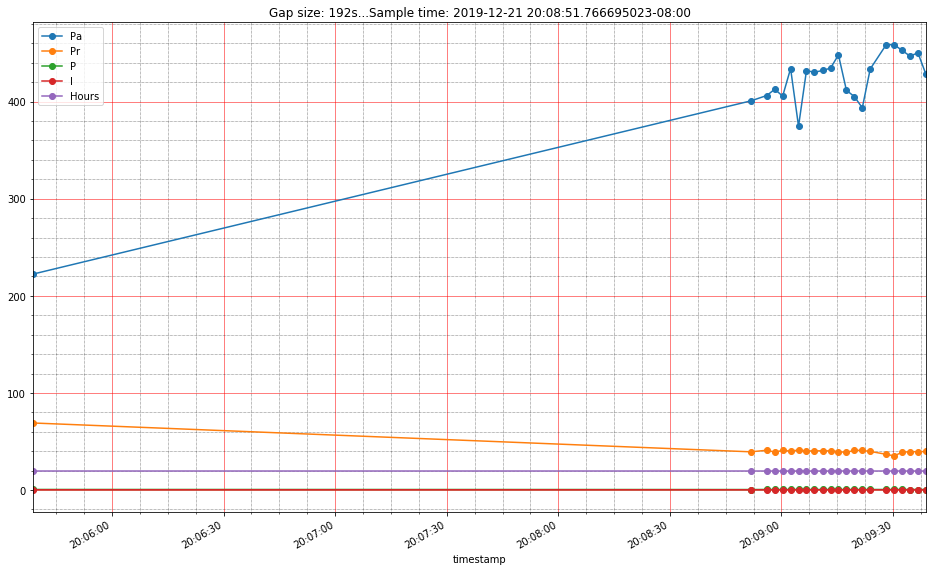

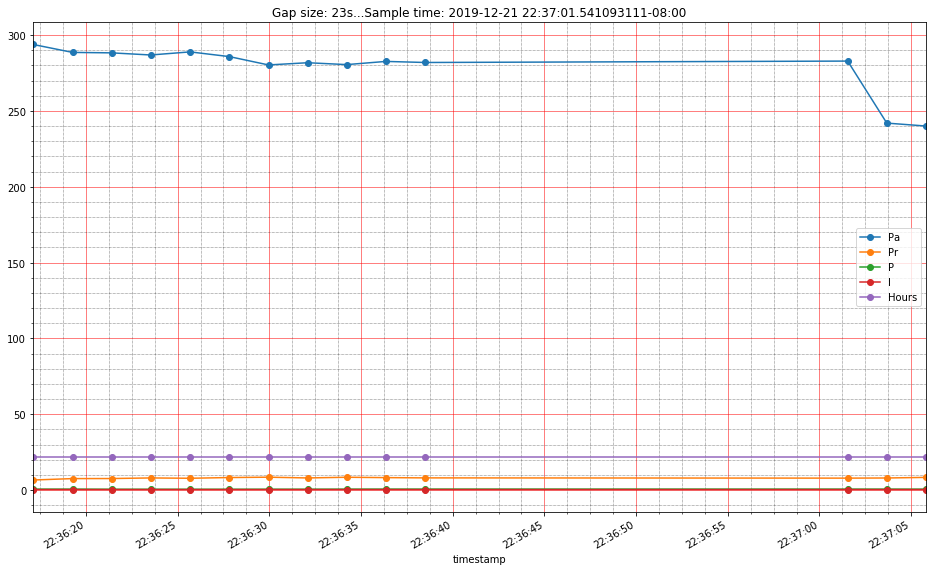

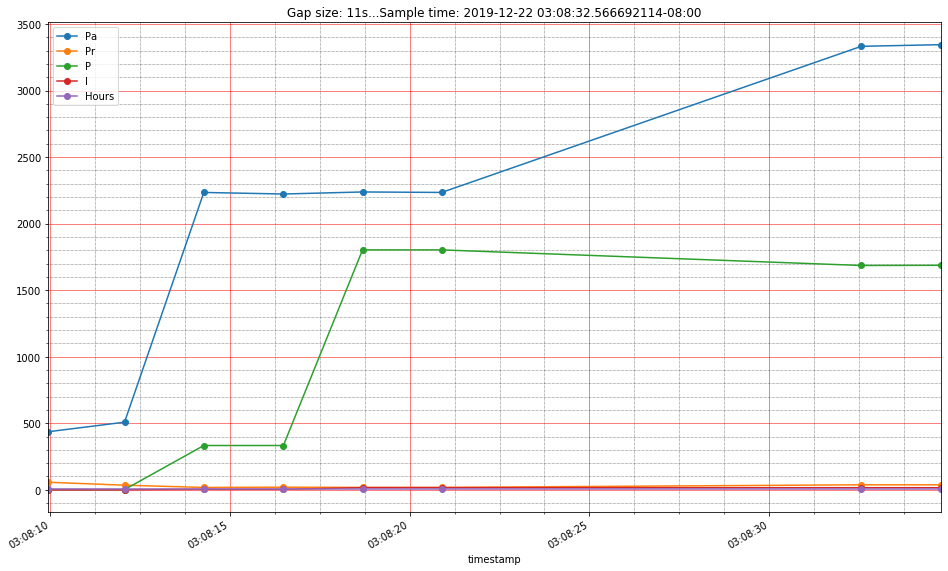

In [8]:
plot_gaps(df_data,df_time_between_samples,10)

# Thoughts on Gaps
There should be no gaps.  All readings should be 2 seconds apart.  But they are not.  I could resample.  But I am not sure how that would improve anything.  For now, I'm not doing any resampling.  This is a judgement call I wish I could talk over with someone more experienced at this than I am.

# Explore the Data
Let's get a feel for how the data works.  Of particular

<function matplotlib.pyplot.show>

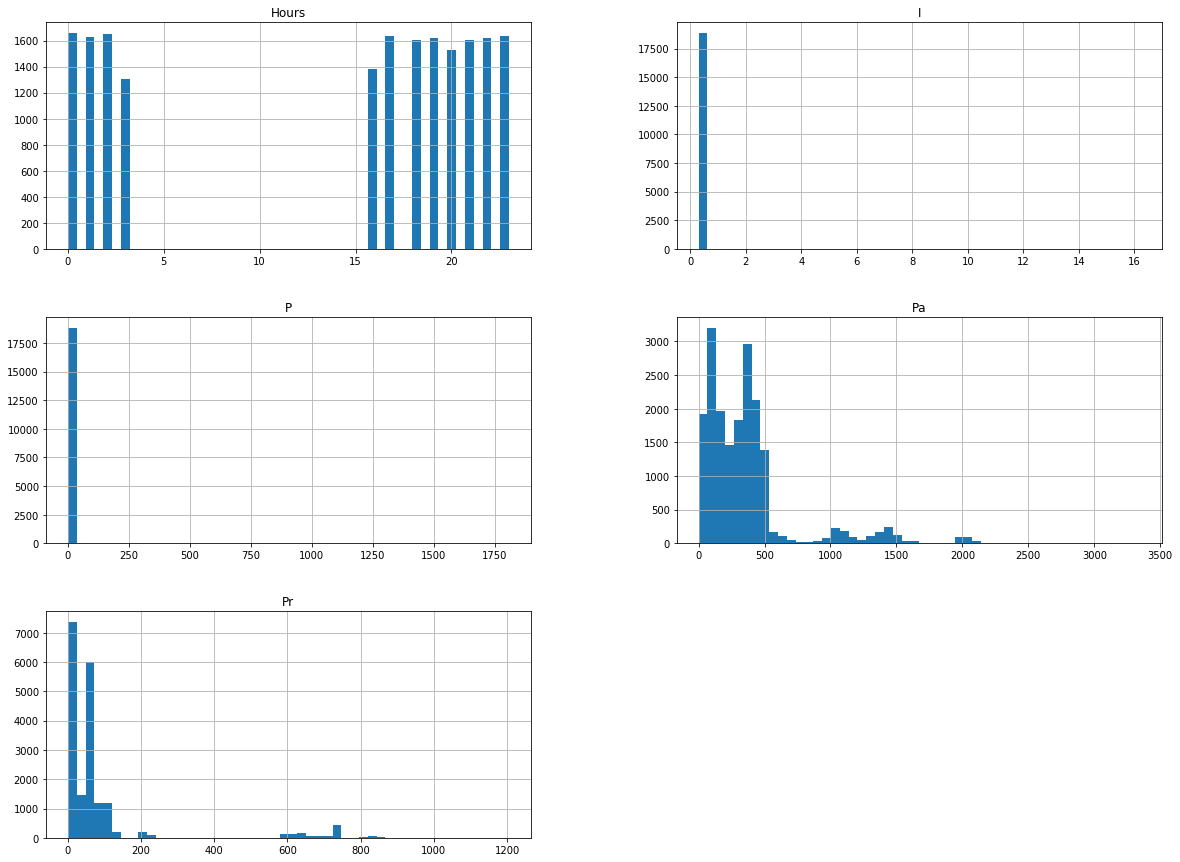

In [9]:
df_data.hist(bins=50,figsize=(20,15))
plt.show

# Plot the Readings

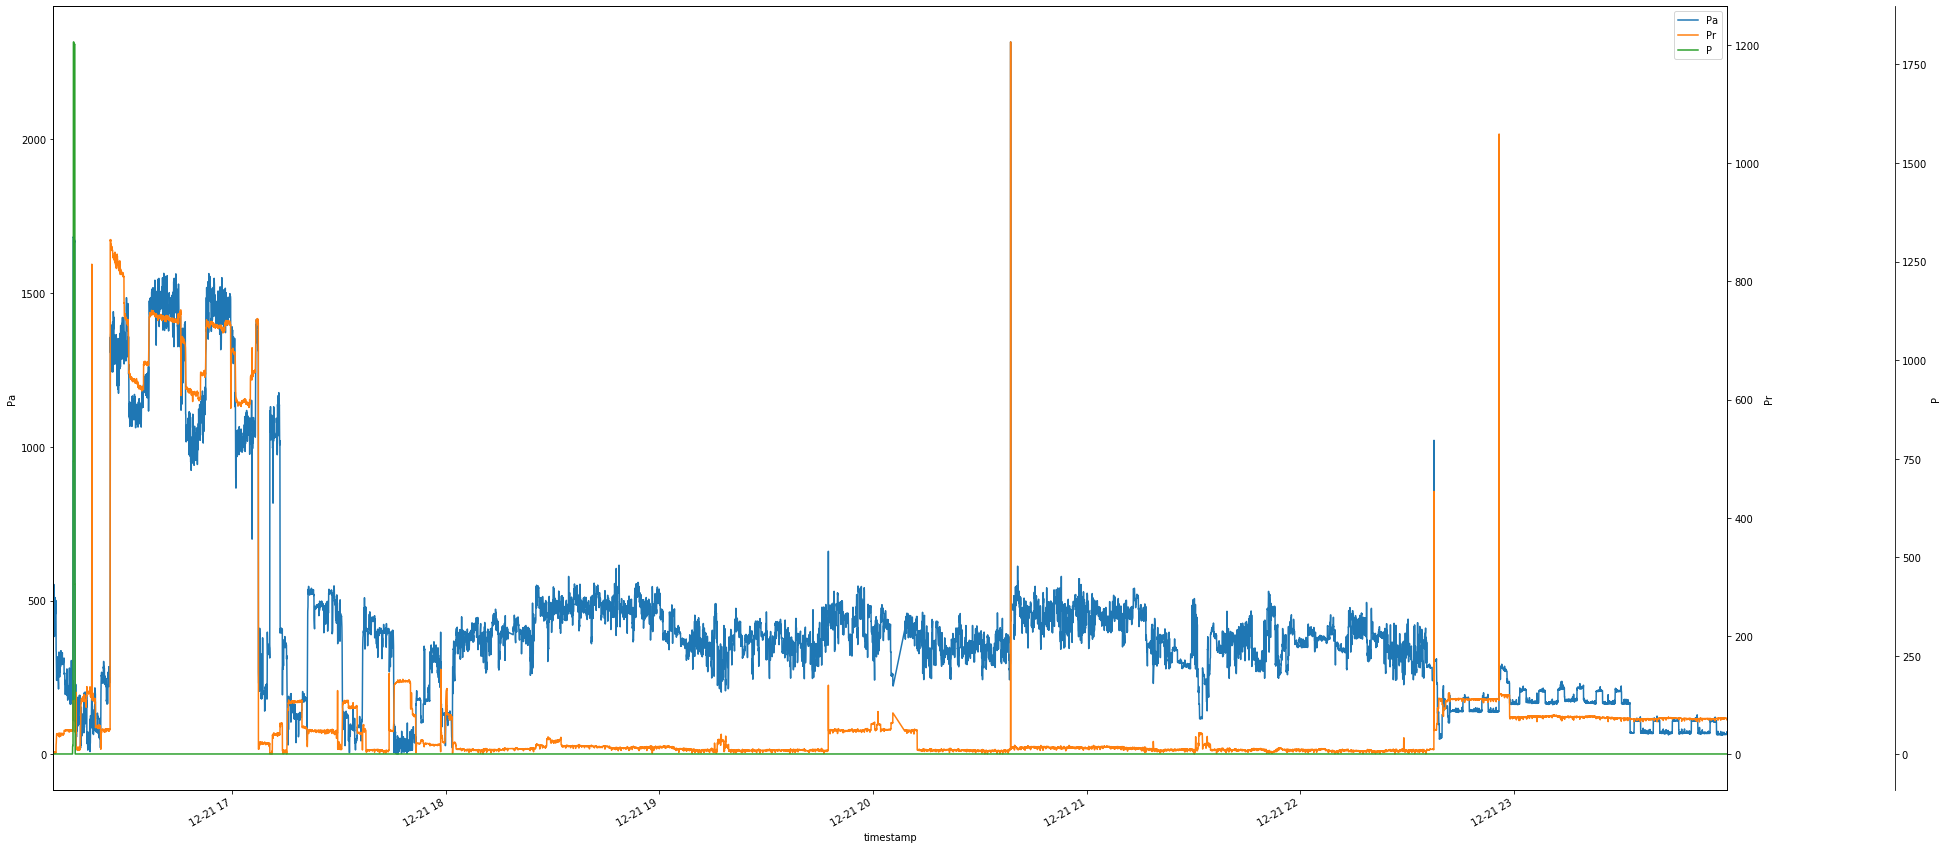

In [17]:
plots.multi_line(df_data['12-21-2019'][['Pa','Pr','P']],figsize=(30,16))

# Change P and I columns to microwave on/off
When the value of 'P' is > than the standard deviation of all values of 'P', the microwave is on.  A new on/off column labeled microwave will be created.    If the readings, detect the microwave is on, the sample value in the microwave column will be 1.  Else, 0.

In [144]:
microwave_on = df_data['P'] > df_data['P'].std()
microwave_on = microwave_on.astype(int)
df_data['microwave'] = microwave_on
df_data.drop(labels=['P','I'],axis=1,inplace=True)
df_data.head()



,Pa,Pr,Hours,microwave
timestamp,,,,
2019-12-21 16:09:48.570688963-08:00,499.6950,0.59232,16,0
2019-12-21 16:09:50.708533049-08:00,489.9481,2.93664,16,0
2019-12-21 16:09:52.851182938-08:00,506.8573,3.15648,16,0
2019-12-21 16:09:54.988461018-08:00,552.3623,1.44768,16,0
2019-12-21 16:09:57.128302097-08:00,499.9504,2.06080,16,0


# Get (Window) Batches Ready
Data will be fed in one hour windows.  The number of one hour windows (known as the batch size) will be